In [1]:
import pandas as pd
import numpy as np
from warnings import simplefilter; simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

import sys
sys.path.append("../boa-learn")

from boa_learn.load import load_nhanes

In [53]:
%%time 
year=2010
df = load_nhanes(year)
df['LBXCRP']=np.log(df.LBXCRP)
df['years_until_death']=df['months_until_death']/12

CPU times: user 474 ms, sys: 72.2 ms, total: 547 ms
Wall time: 10.9 s


<AxesSubplot:xlabel='timeline'>

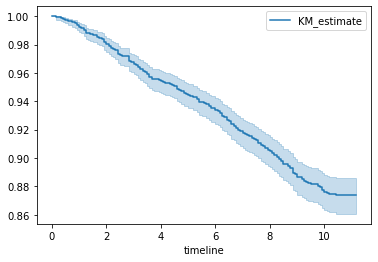

In [63]:
T=df.years_until_death
E=df.is_dead
kmf = KaplanMeierFitter()
kmf.fit(T, E)  
kmf.plot()
plt.ylabel('Survival');plt.xlabel('Years');

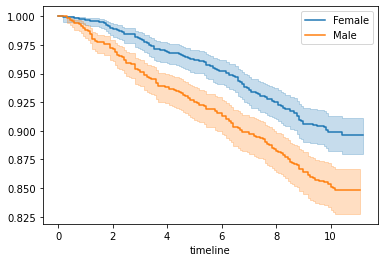

In [64]:
ax=plt.subplot()
groups = df['sex']
ix = (groups == 2)
kmf.fit(T[ix], E[ix], label='Female')
ax = kmf.plot_survival_function(ax=ax)
kmf.fit(T[~ix], E[~ix], label='Male')
ax = kmf.plot_survival_function()
plt.ylabel('Survival');plt.xlabel('Years');

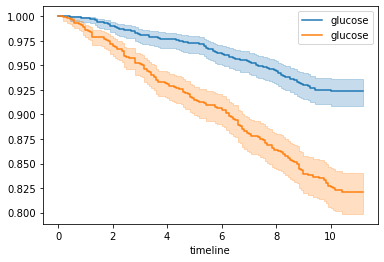

In [65]:
ax=plt.subplot()
groups = df['glucose']
ix = (groups < 5.5)
kmf.fit(T[ix], E[ix], label='glucose')
ax = kmf.plot_survival_function(ax=ax)
kmf.fit(T[~ix], E[~ix], label='glucose')
ax = kmf.plot_survival_function()
plt.ylabel('Survival');plt.xlabel('Years');

In [66]:
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5940111/
pheno_coefs={
    'age':0.0804,
    'LBDSALSI':-0.034,
    'LBDSCRSI':0.0095,
    'glucose':0.1953, 
    'LBXCRP':0.0954,
    'LBXLYPCT':-0.012,
    'LBXMCVSI':0.0268,
    'LBXRDW':0.3356,
    'LBXSAPSI':0.00188,
    'LBXWBCSI':0.0554,
}

In [68]:
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5940111/
constant = -19.9067
gamma = 0.0077
cs=[141.50225,-0.00553,0.090165]
df['pheno']=df.apply(lambda x:sum([x[c]*pheno_coefs[c] for c in pheno_coefs.keys()]) ,axis=1)
df['mortality_score'] = 1-np.exp((-np.exp(constant+df['pheno'])*((np.exp(120*gamma)-1)/gamma)))
df['phenotypic_age'] = cs[0] + np.log(cs[1] * np.log(1-df['mortality_score']))/cs[2]

<AxesSubplot:xlabel='age', ylabel='phenotypic_age'>

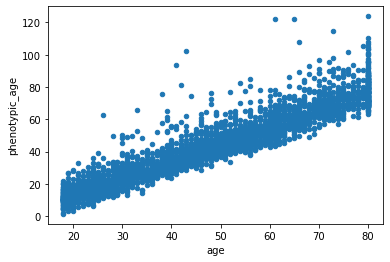

In [69]:
df.plot.scatter('age','phenotypic_age')

In [70]:
df['biologically_older']=df['phenotypic_age']>df['age']

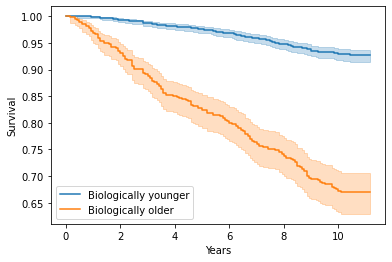

In [75]:
ax=plt.subplot()
groups = df['biologically_older']
ix = (groups == 0)
kmf.fit(T[ix], E[ix], label='Biologically younger')
ax = kmf.plot_survival_function(ax=ax)
kmf.fit(T[~ix], E[~ix], label='Biologically older')
ax = kmf.plot_survival_function()
plt.ylabel('Survival');plt.xlabel('Years');

In [80]:
#train model using another cohort-year -> need to move to a separate notebook
year=2012
df = load_nhanes(year)
X_train=df[['age','sex','glucose']+cbc_sub]
y_train=df['is_dead']
logreg= LogisticRegression(max_iter=1000)
logreg.fit(X_train,y_train)
df=pd.read_csv('2010.csv',index_col=0)
X_test=df[['age','sex','glucose']+cbc_sub]
y_test=df['is_dead']
y_pred=logreg.predict(X_test)
y_pred_proba= logreg.predict_proba(X_test) [::,1]
false_positive_rate, true_positive_rate, _ = metrics.roc_curve(y_test, y_pred_proba)
auc= metrics.roc_auc_score(y_test, y_pred_proba)

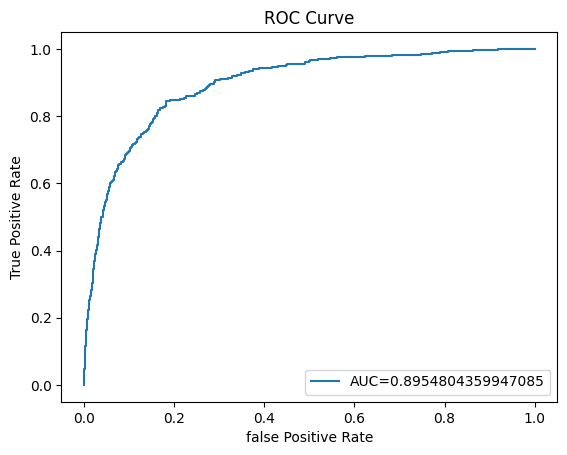

In [81]:
plt.plot(false_positive_rate, true_positive_rate,label="AUC="+str(auc))
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('false Positive Rate')
plt.legend(loc=4)

In [82]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94      2555
         1.0       0.71      0.27      0.39       358

    accuracy                           0.90      2913
   macro avg       0.81      0.63      0.67      2913
weighted avg       0.88      0.90      0.88      2913



In [88]:
df['biologically_older']=y_pred

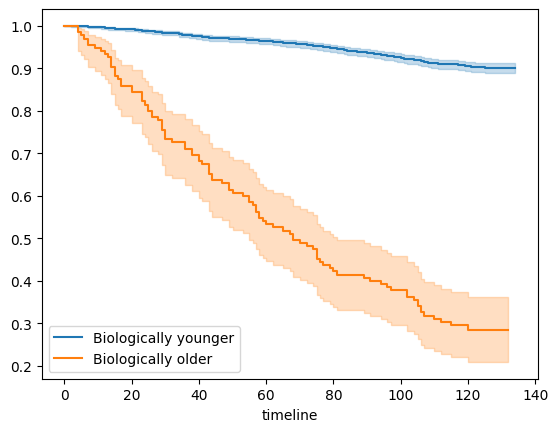

In [89]:
ax=plt.subplot()
groups = df['biologically_older']
ix = (groups == 0)
kmf.fit(T[ix], E[ix], label='Biologically younger')
ax = kmf.plot_survival_function(ax=ax)
kmf.fit(T[~ix], E[~ix], label='Biologically older')
ax = kmf.plot_survival_function()

In [90]:
year=2010
df.to_csv(f'nhanes-{year}.csv')